## Reproduce PySM 2 synchrotron polarization templates

The purpose of this notebook is to reproduce the analysis described in the [PySM 2 paper](https://arxiv.org/pdf/1608.02841.pdf) to prepare the input templates used in the Galactic dust and synchrotron models.
In summary we take input template maps from Planck or other sources, smooth them to remove noise and add small scale gaussian fluctuations.

In [1]:
import os
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
%matplotlib inline

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "32"

In [3]:
hp.disable_warnings()

In [4]:
plt.style.use("seaborn-talk")

In [5]:
import pysm3 as pysm
import pysm3.units as u

In [6]:
nside = 512
lmax = 3 * nside - 1

## Masks

For synchrotron we use the WMAP polarization analysis mask

In [7]:
wmap_mask_filename = "wmap_polarization_analysis_mask_r9_9yr_v5.fits"

In [8]:
if not os.path.exists(wmap_mask_filename):
    !wget https://lambda.gsfc.nasa.gov/data/map/dr5/ancillary/masks/$wmap_mask_filename

In [9]:
fits.open(wmap_mask_filename)[1].header

XTENSION= 'BINTABLE'           /binary table extension                          
BITPIX  =                    8 /8-bit bytes                                     
NAXIS   =                    2 /2-dimensional binary table                      
NAXIS1  =                    8 /width of table in bytes                         
NAXIS2  =              3145728 /number of rows in table                         
PCOUNT  =                    0 /size of special data area                       
GCOUNT  =                    1 /one data group (required keyword)               
TFIELDS =                    2 /number of fields in each row                    
TTYPE1  = 'TEMPERATURE'        /label for field 1                               
TFORM1  = 'E       '           /data format of field: 4-byte REAL               
TUNIT1  = 'mK      '           /physical unit of field 1                        
TTYPE2  = 'N_OBS   '           /label for field 2                               
TFORM2  = 'E       '        

In [10]:
wmap_mask = hp.read_map(wmap_mask_filename,0)

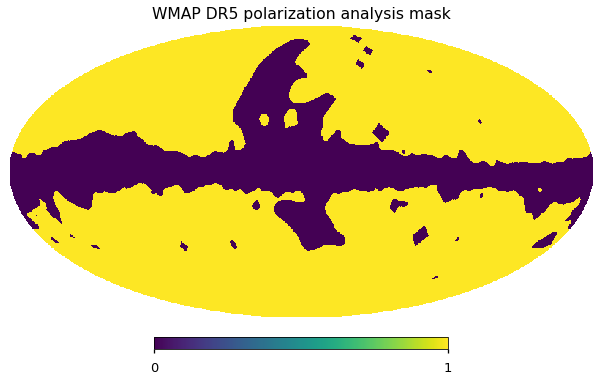

In [11]:
hp.mollview(wmap_mask, title="WMAP DR5 polarization analysis mask")

In [12]:
total_mask = hp.ud_grade(wmap_mask, nside)

In [13]:
f_sky = total_mask.sum()/len(total_mask)

In [14]:
f_sky

0.7315705617268881

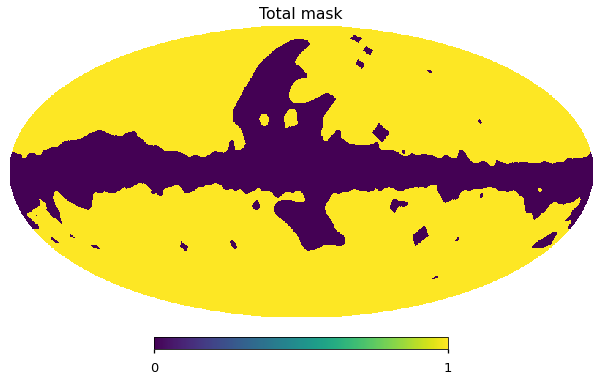

In [15]:
hp.mollview(total_mask, title="Total mask")

## Synchrotron model

### Spectral index

As in the nominal Planck Sky Model v1.7.8 simulations,
we use the spectral index map from ‘Model 4’ of [MivilleDeschenes et al. (2008)](https://arxiv.org/abs/0802.3345), calculated from a combination of
Haslam and WMAP 23 GHz polarization data using a model
of the Galactic magnetic field.

In [16]:
pysm2_beta = hp.read_map("https://portal.nersc.gov/project/cmb/pysm-data/pysm_2/synch_beta.fits")

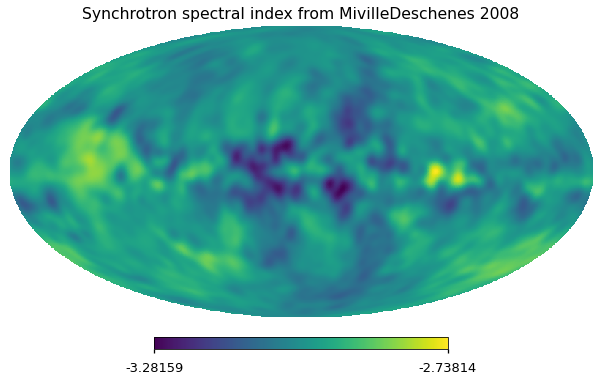

In [17]:
hp.mollview(pysm2_beta, title="Synchrotron spectral index from MivilleDeschenes 2008")

In [18]:
hp.npix2nside(len(pysm2_beta))

512

## Synchrotron templates

The nominal PySM model assumes that the synchrotron intensity is a scaling of the degree-scale-smoothed 408 MHz
Haslam map (Haslam et al. 1981; Haslam et al. 1982), reprocessed by [Remazeilles et al. (2014)](https://arxiv.org/abs/1411.3628v1). It models the polarization as a scaling of the WMAP 9-year 23 GHz Q and U
maps (Bennett et al. 2013), smoothed to three degrees.


In [19]:
wmap_23GHz_map_filename = "wmap_band_iqumap_r9_9yr_K_v5.fits"

In [20]:
if not os.path.exists(wmap_23GHz_map_filename):
    !wget https://lambda.gsfc.nasa.gov/data/map/dr5/skymaps/9yr/raw/$wmap_23GHz_map_filename

In [21]:
wmap_23GHz_map,wmap_23GHz_header = hp.read_map(wmap_23GHz_map_filename, (0,1,2), h=True)

In [22]:
wmap_23GHz_header

[('XTENSION', 'BINTABLE'),
 ('BITPIX', 8),
 ('NAXIS', 2),
 ('NAXIS1', 16),
 ('NAXIS2', 3145728),
 ('PCOUNT', 0),
 ('GCOUNT', 1),
 ('TFIELDS', 4),
 ('TTYPE1', 'TEMPERATURE'),
 ('TFORM1', 'E'),
 ('TUNIT1', 'mK,thermodynamic'),
 ('TTYPE2', 'Q_POLARISATION'),
 ('TFORM2', 'E'),
 ('TUNIT2', 'mK,thermodynamic'),
 ('TTYPE3', 'U_POLARISATION'),
 ('TFORM3', 'E'),
 ('TUNIT3', 'mK,thermodynamic'),
 ('TTYPE4', 'N_OBS'),
 ('TFORM4', 'E'),
 ('TUNIT4', 'counts'),
 ('EXTNAME', 'Stokes Maps'),
 ('DATE', 0),
 ('PIXTYPE', 'HEALPIX'),
 ('ORDERING', 'NESTED'),
 ('NSIDE', 512),
 ('FIRSTPIX', 0),
 ('LASTPIX', 3145727)]

In [23]:
wmap_23GHz_map <<= u.mK_CMB

In [24]:
wmap_23GHz_map 

<Quantity [[-0.03986083,  0.02449621,  0.02531876, ...,  0.00221002,
             0.07428655,  0.05724607],
           [ 0.09875185,  0.10571568,  0.01903246, ..., -0.00060688,
            -0.00214752,  0.04822671],
           [ 0.14018975,  0.00601351,  0.07239608, ...,  0.11238982,
             0.07078604,  0.03262439]] mK_CMB>

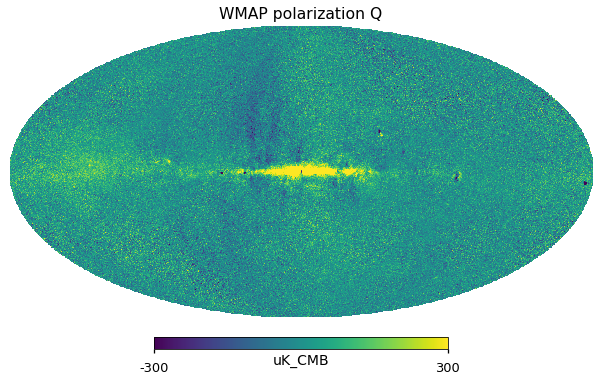

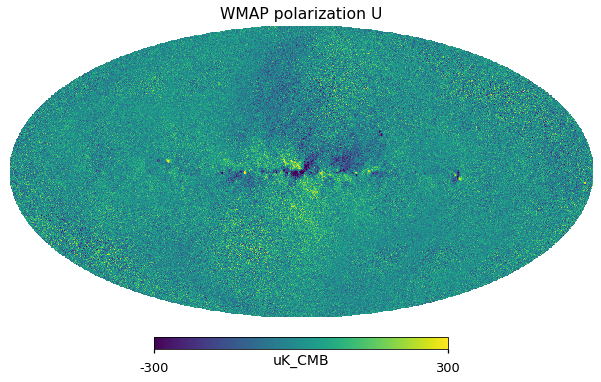

In [25]:
for i_pol, pol in [(1, "Q"), (2, "U")]:
    hp.mollview(wmap_23GHz_map[i_pol].to_value("uK_CMB"), title="WMAP polarization " + pol, unit="uK_CMB", min=-300, max=300)

In [26]:
target_unit = u.uK_RJ

In [27]:
K_CMB_2_K_RJ = (1 * wmap_23GHz_map.unit).to_value(target_unit , equivalencies=u.cmb_equivalencies(23*u.GHz))

In [28]:
K_CMB_2_K_RJ

986.4426641608574

This is the effective frequency of the WMAP K band using the effective frequency calculator from <https://lambda.gsfc.nasa.gov/product/map/current/effective_freq.cfm> using a spectral index of -3:

In [29]:
(1 * u.K_CMB).to(u.K_RJ , equivalencies=u.cmb_equivalencies(2.24357e+01*u.GHz))

<Quantity 0.98709465 K_RJ>

In [30]:
smoothing_fwhm = 3 * u.deg

In [31]:
ell_star_synch = 36

In [32]:
#synch_amplitude = hp.smoothing(wmap_23GHz_map.value, fwhm=(180 * u.deg / ell_star_synch).to_value(u.rad)) * wmap_23GHz_map.unit

In [33]:
synch_amplitude = wmap_23GHz_map

In [34]:
wmap_23GHz_frequency = 2.24357e+01*u.GHz

In [35]:
synch_amplitude = synch_amplitude.to(target_unit, equivalencies=u.cmb_equivalencies(wmap_23GHz_frequency))[1:]

## Angular power spectrum

We use namaster to estimate the power spectrum of the masked map,
compared to `anafast`, namaster properly deconvolves the mask to remove the
correlations between different $C_\ell$ caused by the mask.

We don't need to deconvolve the beam, we won't be using the values at high $\ell$ anyway.

In [36]:
from reprocess_utils import run_namaster

In [37]:
ell, cl = run_namaster(synch_amplitude, total_mask)

In [38]:
import pymaster as nmt
mask = total_mask
m = synch_amplitude

In [39]:
    binning = nmt.NmtBin.from_nside_linear(hp.npix2nside(m.shape[-1]), 1) 
    ell_arr = binning.get_effective_ells() 
    ell_arr = np.concatenate([[0, 0], ell_arr]) 
    f_2 = nmt.NmtField( 
        mask, m.copy() 
    )  # namaster overwrites the map in place with the mask 
    cl_22 = nmt.compute_full_master(f_2, f_2, binning) 
    cl = np.zeros((3, len(ell_arr)), dtype=np.double) 
    cl[1, 2:] = cl_22[0] 
    cl[2, 2:] = cl_22[3] 


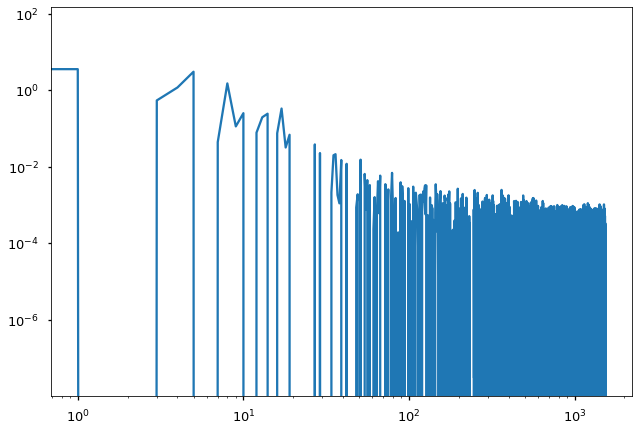

In [40]:
plt.loglog(cl_22[2])

In [41]:
cl.shape

(3, 1536)

In [42]:
cl_norm = ell*(ell+1)/np.pi/2

We plot the output power spectrum and also identify a range in $\ell$ before white noise starts dominating
and after the uncertainty at low-$\ell$.

The power spectrum features a power law behaviour $\ell < 200$ (linear in `loglog` axes), then white noise
starts picking up until $\ell=1000$ and then we see the smoothing applied to the maps (10 arcminutes).

In [43]:
ell_fit_low = 2
ell_fit_high = 80

### Fit noise bias

In [44]:
noise_bias_ell_low = 700
noise_bias_ell_high = 1000
noise_bias = (cl[1:, noise_bias_ell_low:noise_bias_ell_high]).mean(axis=1)
noise_bias = {"EE":noise_bias[0], "BB":noise_bias[1]}

In [45]:
# noise_bias["BB"] = noise_bias["EE"]

In [46]:
noise_bias

{'EE': 0.015947944576014617, 'BB': 0.016036643055908954}

/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if sys.path[0] == '':


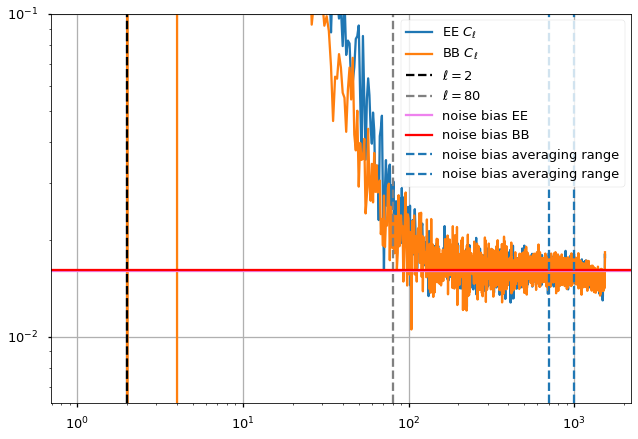

In [47]:
plt.plot(cl[1], label="EE $C_\ell$")
plt.loglog(cl[2], label="BB $C_\ell$")
plt.axvline(ell_fit_low, linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low))
plt.axvline(ell_fit_high, linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high))
for pol,color in zip(["EE", "BB"], ["violet", "red"]):
    plt.axhline(noise_bias[pol], color=color, label=f"noise bias {pol}")
plt.axvline(noise_bias_ell_low, ls="--", label=f"noise bias averaging range")
plt.axvline(noise_bias_ell_high, ls="--", label=f"noise bias averaging range")

plt.legend()
#plt.xlim(2,200)
plt.ylim(0,.1)
plt.grid();

In [48]:
(cl_norm * cl[2])[2]

30.3156583368453

In [49]:
cosmic_variance = np.sqrt(2/((2*ell+1)*f_sky))*cl

In [50]:
cosmic_variance

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.64565298e+02, ...,
        5.18685174e-04, 5.39284500e-04, 5.26832396e-04],
       [0.00000000e+00, 0.00000000e+00, 2.34745625e+01, ...,
        4.88834528e-04, 5.44243575e-04, 5.45132045e-04]])

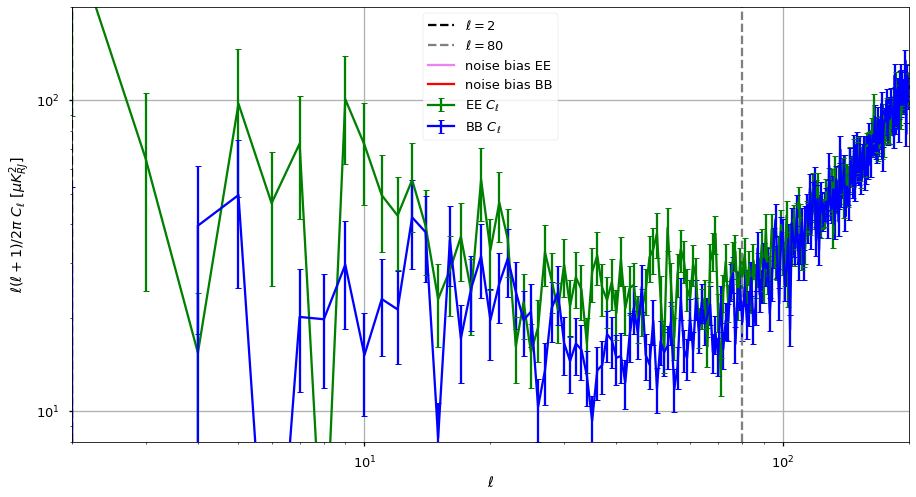

In [51]:
plt.figure(figsize=(15,8))
plt.errorbar(ell, cl_norm* cl[1], yerr=cosmic_variance[1]*cl_norm, color="green", label="EE $C_\ell$", mew=1, capsize=3)
plt.errorbar(ell, cl_norm * cl[2], yerr=cosmic_variance[2]*cl_norm, color="blue", label="BB $C_\ell$", mew=1, capsize=3)
plt.axvline(ell_fit_low, linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low))
plt.axvline(ell_fit_high, linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high))
for pol,color in zip(["EE", "BB"], ["violet", "red"]):
    plt.axhline(noise_bias[pol], color=color, label=f"noise bias {pol}")
plt.legend()
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)/2\pi~C_\ell~[\mu K_{RJ}^2]$")

plt.xlim(2,200)
plt.ylim(8,2e2)
plt.grid();

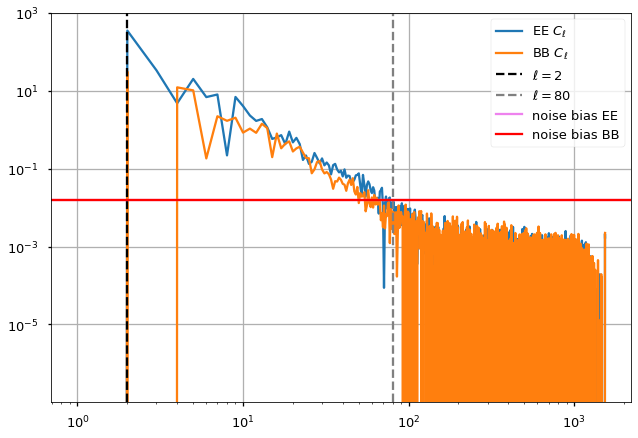

In [52]:
plt.loglog(cl[1]-noise_bias["EE"], label="EE $C_\ell$")
plt.plot(cl[2]-noise_bias["BB"], label="BB $C_\ell$")
plt.axvline(ell_fit_low, linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low))
plt.axvline(ell_fit_high, linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high))
for pol,color in zip(["EE", "BB"], ["violet", "red"]):
    plt.axhline(noise_bias[pol], color=color, label=f"noise bias {pol}")
plt.legend()

#plt.xlim(2,200)
plt.grid();

### Fit slope at high ell

In [53]:
from scipy.optimize import curve_fit

In [54]:
def model(ell, A, gamma):
    return A * ell ** gamma# + N* ell*(ell+1)/np.pi/2

In [55]:
xdata = np.arange(ell_fit_low, ell_fit_high)

In [56]:
cl_norm

array([0.00000000e+00, 0.00000000e+00, 9.54929659e-01, ...,
       3.74272266e+05, 3.74760553e+05, 3.75249159e+05])

/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in power
  # This is added back by InteractiveShellApp.init_path()
/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in power
  # This is added back by InteractiveShellApp.init_path()


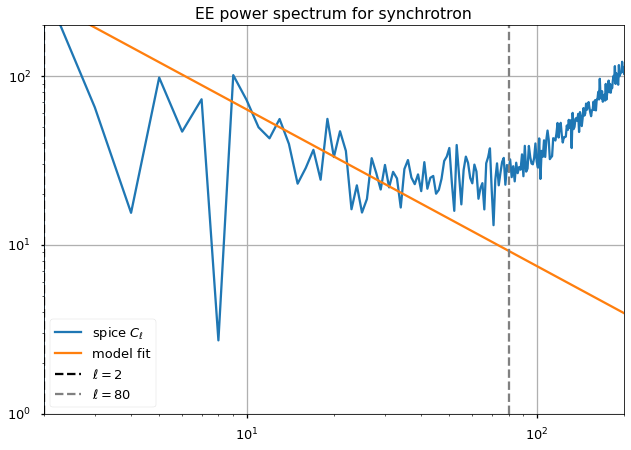

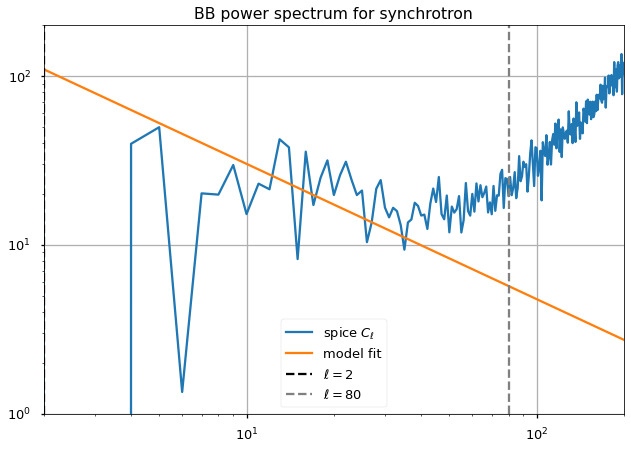

In [57]:
A_fit, gamma_fit, A_fit_std, gamma_fit_std = {},{},{},{}
N_fit = {}
for pol,i_pol in [("EE",1),("BB",2)]:
    ydata = xdata*(xdata+1)/np.pi/2 * (cl[i_pol][xdata] - noise_bias[pol])
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata, sigma=(cosmic_variance[i_pol])[ell_fit_low:ell_fit_high])

    #A_fit_std[pol], gamma_fit_std[pol] = np.sqrt(np.diag(cov))
    plt.figure()
    plt.loglog(ell*(ell+1)/np.pi/2 * (cl[i_pol]), label="spice $C_\ell$")

    plt.loglog(A_fit[pol]*ell**gamma_fit[pol], label="model fit")
    plt.axvline(ell_fit_low, linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low))
    plt.axvline(ell_fit_high, linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high))
    plt.legend()
    plt.grid()
    plt.title(f"{pol} power spectrum for synchrotron")
    plt.xlim(2,200)
    plt.ylim(1,200)
    #plt.ylim(1, 30);

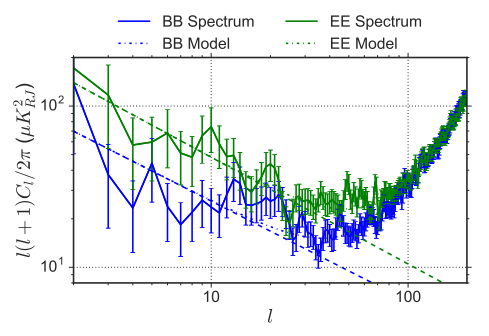

In [58]:
from IPython.display import Image
Image("BB_synch_inputs_PySM_2_paper.png")

The paper mentions a $\gamma^{EE,synch} = -.66$ and a $\gamma^{BB,synch} = -.62$.


In [59]:
gamma_fit

{'EE': -0.9271577933916797, 'BB': -0.8010580744726311}

### Window function

The window function is used to smooth the input templates to remove the high $\ell$ noise and its inverse is used for the added small scales.

In the paper it mentions that the large scales map is smoothed with a beam of $180/\ell_*^{synch}$ degrees, but looking at the PySM 2 templates, it looks like the spectrum is still flat after the supposed cutoff of the beam, see the end of this notebook.

So I tested using the same $\ell_*$ used for dust, i.e. 2.6 deg smoothingi instead of 5, but still the spectrum in PySM 2 seems flatter at intermediate $\ell$.

$\ell_*^{synch}$

In [60]:
ell_star = 36
ell_star = 69

In [61]:
theta_fwhm_deg = 180/ell_star

In [62]:
theta_fwhm_deg

2.608695652173913

In [63]:
theta_fwhm = np.radians(theta_fwhm_deg)

In [64]:
w_ell = hp.gauss_beam(fwhm=theta_fwhm, lmax=lmax)

In [65]:
w_ell.shape

(1536,)

## Process patches

This process doesn't have a large impact on the output spectra, the idea is that in each $N_{side}=2$ pixel we want to scale the gaussian fluctuations so that they are consistent with the power at low ell.
So we will have higher gaussian fluctuations on the galaxy where there is stronger dust emission.

In [66]:
patch_indices = hp.ud_grade(np.arange(hp.nside2npix(2)), nside)

In [67]:
zeros = np.zeros(len(ell), dtype=np.double)

In [68]:
inv_w_ell = 1 - w_ell**2

In [69]:
nside_patches = 2
n_patches = hp.nside2npix(nside_patches)

In [70]:
m_sigma_G = hp.synfast([
    zeros,
    A_fit["EE"] * ell**gamma_fit["EE"] * inv_w_ell / cl_norm,A_fit["BB"] * ell**gamma_fit["BB"] * inv_w_ell / cl_norm,
    zeros, zeros, zeros], nside, new=True)

/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


In [71]:
N = {i_pol:np.zeros(n_patches, dtype=np.double) for i_pol in [1,2]}

In [72]:
synch_amplitude = wmap_23GHz_map.to(u.uK_RJ, equivalencies=u.cmb_equivalencies(wmap_23GHz_frequency))

In [73]:
synch_amplitude[0]=0

In [74]:
m_planck_smoothed = hp.alm2map(hp.smoothalm(hp.map2alm(synch_amplitude.value, use_pixel_weights=True), fwhm=theta_fwhm),
                               nside=nside)

In [75]:
for i_patch in range(n_patches):
    print(i_patch)
    m_patch = np.zeros_like(m_planck_smoothed)
    m_patch[1:, patch_indices == i_patch] = m_planck_smoothed[1:, patch_indices == i_patch]
    cl_patch = hp.anafast(m_patch, lmax=2*ell_star, use_pixel_weights=True)
    for pol,i_pol in [("EE", 1),("BB",2)]:
        N[i_pol][i_patch] = np.sqrt(cl_patch[i_pol][ell_star] / n_patches / (A_fit[pol] * ell_star ** gamma_fit[pol]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


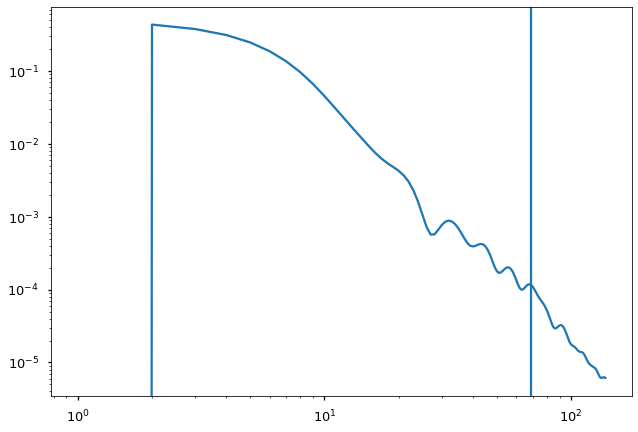

In [76]:
plt.loglog(cl_patch[1])
plt.axvline(ell_star)

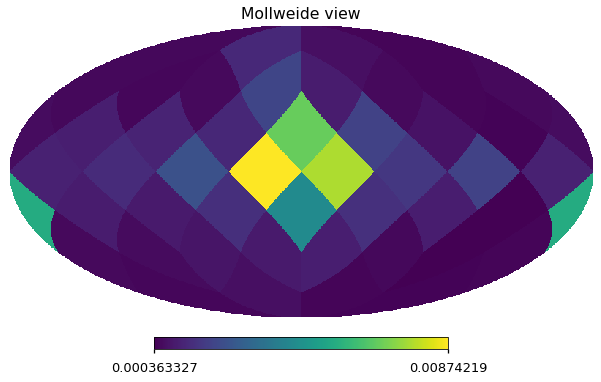

In [77]:
hp.mollview(N[1])

In [78]:
m_zeros = np.zeros(hp.nside2npix(nside), dtype=np.double)

In [79]:
N_smoothed = hp.smoothing([m_zeros, hp.ud_grade(N[1], nside), hp.ud_grade(N[2], nside)], fwhm=np.radians(10))

In [80]:
N_smoothed[1] /= N_smoothed[1].mean()

In [81]:
N_smoothed[2] /= N_smoothed[2].mean() 

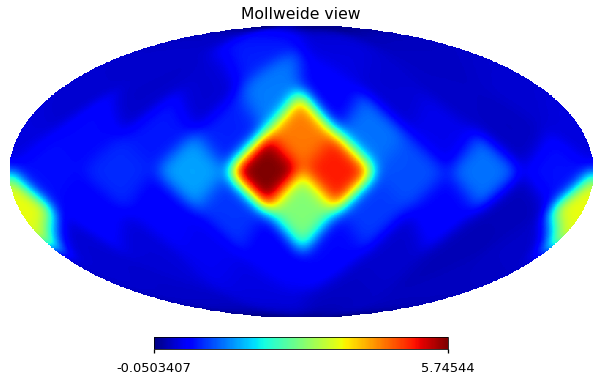

In [82]:
hp.mollview(N_smoothed[1], cmap="jet")

This also is quite different from Figure 9 in the paper, but it is not the main issue, possibly I need to use PolSpice instead of anafast?

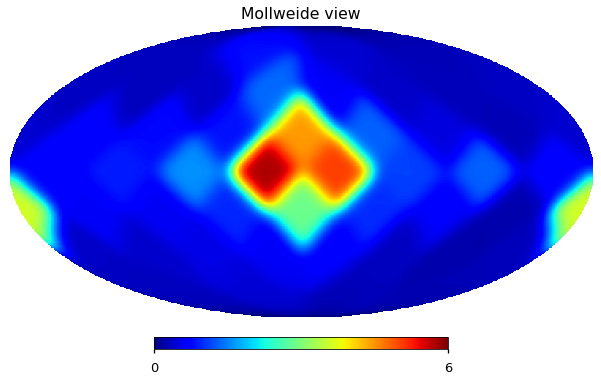

In [83]:
hp.mollview(N_smoothed[1], min=0, max=6, cmap="jet")

## Run PolSpice on the total map and just on the small scales

Always using the same Gal80 Planck mask

In [84]:
m_total = m_planck_smoothed + m_sigma_G * N_smoothed

In [85]:
m_total[0] = 1

In [86]:
_, cl_total = run_namaster(m_total[1:], total_mask)

In [87]:
m_sigma_G[0]=0

In [88]:
_, cl_sigma_G_uniform = run_namaster(m_sigma_G[1:], total_mask)

## Download PySM 2 templates

In [89]:
for comp in "qu":
    filename = f"synch_{comp}_new.fits"
    if not os.path.exists(filename):
        !wget https://portal.nersc.gov/project/cmb/pysm-data/pysm_2/$filename

In [90]:
m_pysm2 = np.array([hp.read_map(f"synch_{comp}_new.fits") for comp in "qu"])

In [91]:
total_mask_512 = hp.ud_grade(total_mask, 512)>=.75

In [92]:
ell_arr_512, cl_pysm2 = run_namaster(m_pysm2, total_mask_512)

## Compare PySM 2, the input and the output

/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':
/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':


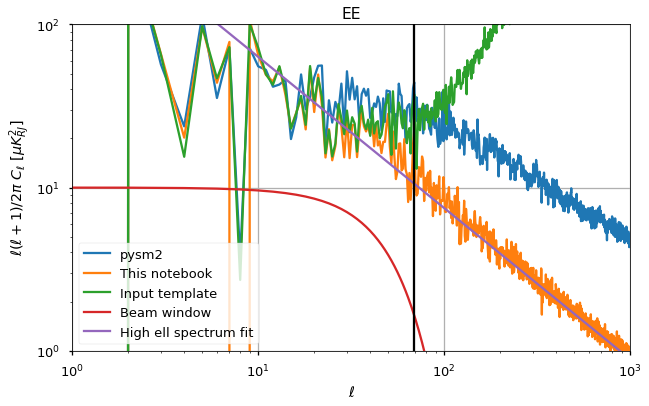

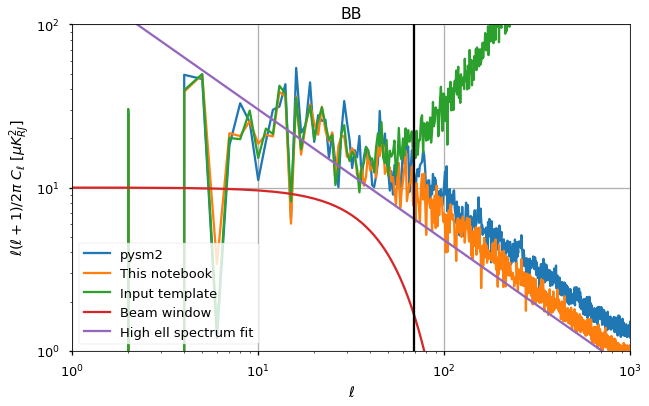

In [93]:
for pol, i_pol in [("EE",1),("BB",2)]:
    plt.figure(figsize=(10,6))
    plt.loglog(cl_norm[:cl_pysm2.shape[1]]*cl_pysm2[i_pol], label="pysm2")
    #plt.loglog(cl_norm*cl_sigma_G_normalized[i_pol], label="SS")
    plt.loglog(cl_norm*cl_total[i_pol], label="This notebook")

    plt.loglog(cl_norm*cl[i_pol], label="Input template")
    plt.loglog(10*w_ell**2, label="Beam window")
    plt.loglog(A_fit[pol] * ell**gamma_fit[pol], label="High ell spectrum fit")
    plt.axvline(ell_star, color="black")
    plt.title(pol)
    plt.legend()
    plt.xlim([1,1000])
    plt.ylim([1e0, 1e2])
    plt.xlabel("$\ell$")
    plt.ylabel("$\ell(\ell+1)/2\pi~C_\ell~[\mu K_{RJ}^2]$")
    plt.grid();

We can also compare with the synchrotron BB plot (Figure 7) from the PySM 2 paper below

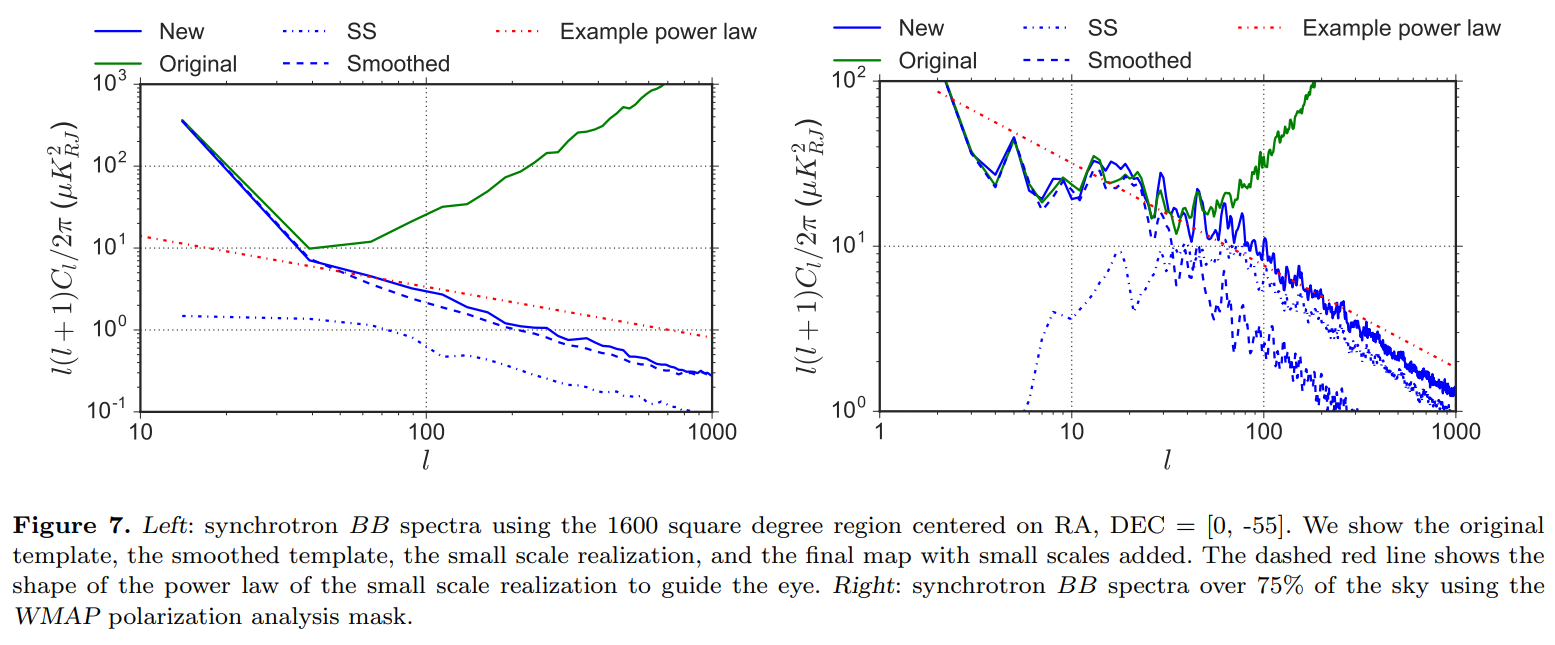

In [94]:
from IPython.display import Image
Image("BB_synch_PySM_2_paper.png")

## Conclusions

There are 2 issue with trying to reproduce the PySM 2 processing of the synchrotron templates for polarization:

* the fit for the slope of the spectra at high $\ell$ gives significantly steeper lines especially for BB, even denoising and considering cosmic variance error in the fit. It is possible that `namaster` gives a slightly different spectrum at low ell, it seems like the spice spectrum for BB has higher values at low $\ell$ impacting the PySM 2 fit
* the figure in cell 93, just above here, shows higher power in the $\ell$ range 60-100 in EE, which should be over the beam cutoff so should just be dominated by the small scales realization

If anyone is interested in investigating this, the source notebook doesn't require any external data and is available [on Github](https://github.com/galsci/pysm/tree/main/docs/template_preprocessing), please [open an issue](https://github.com/galsci/pysm/issues) to report your findings.